In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import time
import scipy.constants as cts
from pylcp.fields import conventional3DMOTBeams

In [2]:
# x is length unit
# k is wavenumber which relates to wavelength
x0 = 0.1 # cm
k = 2*np.pi/461E-7 # cm^{-1}
kbar = k*x0

# D source for position
d = np.array([0., -8.839, -8.839])

# Gamma is decay rate
# t0 is normalized time units of decary
# wb is width factor
gamma = 2*np.pi*30e6
t0 = 1e-5 # s
gammabar = gamma*t0
alpha = 2*np.pi*cts.value('Bohr magneton in Hz/T')*50*1e-4*x0*t0

mbar = 87.9056122571*cts.value('atomic mass constant')*(x0*1e-2)**2/(cts.hbar*t0)

wb = 4.7 # mm

In [3]:
# laser_det = 0
# ham_det = -2.5
# beta = 1.
# transform = True

class aPHIMOT(pylcp.laserBeams):
     def __init__(self, *args, **kwargs):
        super().__init__()
    
        beam_type = kwargs.pop('beam_type', pylcp.laserBeam)
        pol = kwargs.pop('pol', +1)
        kmag = kwargs.pop('k', 1.)
        
        self.add_laser(beam_type(kmag*(np.array([0., 0.,  17.678])/(np.linalg.norm(np.array([0., 0.,  17.678])))), +pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([0., 0.,  -17.678])/(np.linalg.norm(np.array([0., 0.,  -17.678])))), +pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([10.825, -13.258, 4.419])/(np.linalg.norm(np.array([10.825, -13.258, 4.419])))), -pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([10.825, 13.258, -4.419])/(np.linalg.norm(np.array([10.825, 13.258, -4.419])))), -pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([-10.825, -13.258, 4.419])/(np.linalg.norm(np.array([-10.825, -13.258, 4.419])))), -pol, *args, **kwargs))
        self.add_laser(beam_type(kmag*(np.array([-10.825, 13.258, -4.419])/(np.linalg.norm(np.array([-10.825, 13.258, -4.419])))), -pol, *args, **kwargs))
        
class rotDivGauss(pylcp.laserBeams):
     def __init__(self, *args, **kwargs):
        super().__init__()
    
        beam_type = kwargs.pop('beam_type', pylcp.laserBeam)
        pol = kwargs.pop('pol', +1)
        kmag = kwargs.pop('k', 1.)
        beta = kwargs.pop('beta', 1.0)
        delta = kwargs.pop('delta', -1.5*gammabar)
        
        self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([0., 0., -1.]), \
                       pol=np.array([1., -1.j, 0])/np.sqrt(2), beta=1.0*beta, delta=delta, wb=4.65, r0=np.array([0., 0., 0.]), **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([0.612, 0.75, -0.25]), \
                       pol=np.array([1., 1.j, 0])/np.sqrt(2), beta=1.0*beta, delta=delta, wb=4.65, r0=np.array([0., 0., 0.]), **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([-0.612, 0.75, -0.25]), \
                       pol=np.array([1., 1.j, 0])/np.sqrt(2), beta=1.0*beta, delta=delta, wb=4.65, r0=np.array([0., 0., 0.]), **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([0., 0., 1.]), \
                      pol=np.array([1., -1.j, 0])/np.sqrt(2), beta=6.261e7*beta, delta=delta, wb=5.744e-4, r0=np.array([0., 0., -17.788]), **kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([-0.612, -0.75, 0.25]), \
                       pol=np.array([1., 1.j, 0])/np.sqrt(2), beta=6.261e7*beta, delta=delta, wb=5.744e-4, r0=np.array([10.893, 13.341, -4.447]),**kwargs))
        self.add_laser(pylcp.gaussianBeam(kvec=kmag*np.array([0.612, -0.75, 0.25]), \
                       pol=np.array([1., 1.j, 0])/np.sqrt(2), beta=6.261e7*beta, delta=delta, wb=5.744e-4, r0=np.array([-10.893, 13.341, -4.447]), **kwargs))
    

# Set up the laser beams with their appropriate characteristics
# det is detuning of frequency
# alpha relates to magnetic field gradient
# beta is normalized intensity
det = -1.5*gammabar
beta = 1.0

#beam_to_sim = pylcp.infinitePlaneWaveBeam
beam_to_sim = pylcp.gaussianBeam
#beam_to_sim = pylcp.collimatedGaussianBeam

MOT_to_sim = conventional3DMOTBeams
#MOT_to_sim = aPHIMOT
#MOT_to_sim = rotDivGauss

MOT_to_sim_kwargs = {'rotation_angles':[np.pi/4, 0., 0.]} # Extra arguments for conventional3DMOTBeams
#MOT_to_sim_kwargs = {} # Extra arguments for aPHIMOT/rotDivGauss

#laser_kwargs = {} # Use for rotDivGauss
laser_kwargs = {'wb':wb} # Extra arguments for GaussianBeam
#laser_kwargs = {'wb':1000*wb, 'rs':wb} # Extra arguments for clippedGaussianBeam

laserBeams = MOT_to_sim(beta=beta, delta=det, beam_type=beam_to_sim, k=kbar, **laser_kwargs, **MOT_to_sim_kwargs) # kbar

#print(laserBeams.pol())

if (np.sum(np.isnan(laserBeams.pol()), axis=(0, 1)) > 0):
    del laserBeams
    laserBeams = MOT_to_sim(beta=beta, delta=det, beam_type=beam_to_sim, k=kbar, **laser_kwargs, **MOT_to_sim_kwargs)

magField = pylcp.quadrupoleMagneticField(alpha)

In [4]:
z = np.arange(-100, 100.01, 0.25)

heuristic = pylcp.heuristiceq(laserBeams, magField, gamma=gammabar, mass=mbar)
heuristic.generate_force_profile([np.zeros(z.shape), np.zeros(z.shape), z], np.zeros((3,) + z.shape), name='Fz', progress_bar=True)

Completed in 2.44 s.                                               


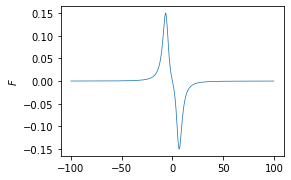

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.75))

ax.plot(heuristic.profile['Fz'].R[2],
           heuristic.profile['Fz'].F[2]/kbar/gammabar,
           label='heuristic', linewidth=0.75)
ax.set_ylabel('$F$')
plt.show()

In [6]:
#laserBeams.beam_vector[0].kvec()

array([9.63749010e+03, 9.63749010e+03, 8.34564292e-13])